In [1]:
import sys
sys.path.append('/home/jacoposala/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
import numpy as np
import xarray as xr
import sys
import glob
import os
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime
from dask.diagnostics import ProgressBar

# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

### Inputs

In [3]:
ECCO_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/'
save_dir = join(ECCO_dir,'outputs')
path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/outputs/nc_files_zlev_or_zint/'

In [4]:
# Specify the desired latitude and longitude values
desired_lat = -0.19937  # Replace with your desired latitude
desired_lon = 215.5  # Replace with your desired longitude

# desired_lat = -35.1757  # Replace with your desired latitude
# desired_lon = 203.5  # Replace with your desired longitude

In [5]:
# Percentile to calculate MHWs
percentile = 90

In [6]:
# Minimum duration of MHW events
delta_tstep = 5 # days

### Load data and extract time series at desired location

In [7]:
# Load data
XC_lon = xr.open_dataset(path + 'ECCOv4r4_XC_lon_1993_2017.nc')
YC_lat = xr.open_dataset(path + 'ECCOv4r4_YC_lat_1993_2017.nc')
Z_depth = xr.open_dataset(path + 'ECCOv4r4_Z_depth_1993_2017.nc')

G_advection_conv_cut = xr.open_dataset(path + 'ECCOv4r4_G_advection_cut_zlev0_2004_2018.nc')
G_diffusion_conv_cut = xr.open_dataset(path + 'ECCOv4r4_G_diffusion_cut_zlev0_2004_2018.nc')
G_forcing_cut = xr.open_dataset(path + 'ECCOv4r4_G_forcing_cut_zlev0_2004_2018.nc')
G_total_cut = xr.open_dataset(path + 'ECCOv4r4_G_total_cut_zlev0_2004_2018.nc')
DATA_cut = xr.open_dataset(path + 'ECCOv4r4_DATA_cut_zlev0_2004_2018.nc')


In [8]:
# Find the nearest grid point to the specified latitude and longitude
lat_lon_distance = np.sqrt((XC_lon['XC_lon'] - desired_lon)**2 + (YC_lat['YC_lat'] - desired_lat)**2)
min_distance_index = np.unravel_index(lat_lon_distance.argmin(), lat_lon_distance.shape)

In [9]:
# Find the nearest grid point to the specified latitude and longitude
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

# Assuming XC_lon and YC_lat are arrays containing longitude and latitude values respectively
# Replace XC_lon and YC_lat with your respective arrays
lat_lon_distance = haversine(YC_lat['YC_lat'], XC_lon['XC_lon'], desired_lat, desired_lon)


In [10]:
min_distance_index = np.unravel_index(lat_lon_distance.argmin(), lat_lon_distance.shape)

In [11]:
# Extract the time series at the selected location
G_advection_conv_cut_timeseries = G_advection_conv_cut['G_advection_cut'].isel(i = min_distance_index[2], j = min_distance_index[1], tile=min_distance_index[0])
G_diffusion_conv_cut_timeseries = G_diffusion_conv_cut['G_diffusion_cut'].isel(i = min_distance_index[2], j = min_distance_index[1], tile=min_distance_index[0])
G_forcing_cut_timeseries = G_forcing_cut['G_forcing_cut'].isel(i = min_distance_index[2], j = min_distance_index[1], tile=min_distance_index[0])
G_total_cut_timeseries = G_total_cut['G_total_cut'].isel(i = min_distance_index[2], j = min_distance_index[1], tile=min_distance_index[0])
DATA_cut_timeseries = DATA_cut['DATA_cut'].isel(i = min_distance_index[2], j = min_distance_index[1], tile=min_distance_index[0])


### Remove trend and seasonal cycle

In [12]:
def remove_trend_seasonalcycle(data_in):
    # Create a copy of the input data to avoid modifying the original
    data_out = data_in.copy(deep=True)

    # Convert 'time' coordinate to datetime
    date_data = pd.to_datetime(data_in['time'].values)

    # Extract month and day from the datetime values
    month_data = date_data.month
    day_data = date_data.day

    # Create a mask for each unique month-day pair
    mmdd = np.unique([month_data, day_data], axis=1)
    
    for i in range(mmdd.shape[1]):

        month_mask = month_data == mmdd[0, i]
        day_mask = day_data == mmdd[1, i]

        # Combine month and day masks to get the final mask
        msk = month_mask & day_mask

        # Calculate the seasonal mean for this month-day pair
        mean_seas = data_in.sel(time=msk).mean(dim='time')

        # Remove the seasonal cycle from the data
        data_out.loc[dict(time=msk)] -= mean_seas

    # Convert 'time' coordinate to numerical values (timestamps)
    time_values = data_in['time'].values.astype(np.int64) // 10**9  # Convert to seconds

    # Detrend the data_out
    trend = np.polyfit(time_values, data_out.values, 1)
    data_out -= np.polyval(trend, time_values)

    # Now, 'data_in' contains the original data with the seasonal cycle removed.
    return data_out


In [13]:
# Remove the seasonal cycle from all the terms
DATA_cut_timeseries_noseasonal_detrended = remove_trend_seasonalcycle(DATA_cut_timeseries)
G_advection_conv_cut_timeseries_noseasonal_detrended = remove_trend_seasonalcycle(G_advection_conv_cut_timeseries)
G_diffusion_conv_cut_timeseries_noseasonal_detrended = remove_trend_seasonalcycle(G_diffusion_conv_cut_timeseries)
G_forcing_cut_timeseries_noseasonal_detrended = remove_trend_seasonalcycle(G_forcing_cut_timeseries)
G_total_cut_timeseries_noseasonal_detrended = remove_trend_seasonalcycle(G_total_cut_timeseries)

# Remove the seasonal cycle only from DATA
# DATA_cut_timeseries_noseasonal_detrended = remove_trend_seasonalcycle(DATA_cut_timeseries)
# G_advection_conv_cut_timeseries_noseasonal_detrended = G_advection_conv_cut_timeseries
# G_diffusion_conv_cut_timeseries_noseasonal_detrended = G_diffusion_conv_cut_timeseries
# G_forcing_cut_timeseries_noseasonal_detrended = G_forcing_cut_timeseries
# G_total_cut_timeseries_noseasonal_detrended = G_total_cut_timeseries

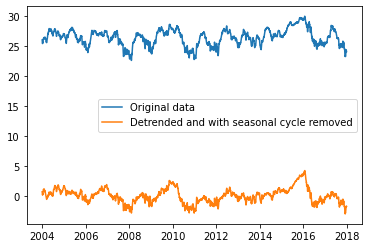

In [14]:
# Plot as sanity check
plt.figure()
plt.plot(DATA_cut_timeseries.time, DATA_cut_timeseries, label = 'Original data')
plt.plot(DATA_cut_timeseries_noseasonal_detrended.time, DATA_cut_timeseries_noseasonal_detrended, label = 'Detrended and with seasonal cycle removed')
plt.legend()

### Calculate time series of percentiles

In [15]:
def calculate_percentiles(data_in, percentile):
    # Create an empty array to store the percentiles
    data_percentile = np.empty(data_in.shape)

    # Define the months to group by (3-month window)
    months = [[12, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7],
              [6, 7, 8], [7, 8, 9], [8, 9, 10], [9, 10, 11], [10, 11, 12], [11, 12, 1]]

    # Convert the input time values to datetime objects
    time_values = xr.DataArray(data_in.coords['time'].values, dims='time')

    for mm in range(12):
        msk_mm = np.zeros(data_in.shape[2:], dtype=bool)
        for months_group in months[mm]:
            msk_mm = np.logical_or(msk_mm, time_values.dt.month == months_group)

        # Calculate the percentile for each grid point and time step within this month group
        data_percentile[msk_mm] = np.repeat(
            np.percentile(data_in[msk_mm], percentile, axis=0, keepdims=True),
            np.sum(msk_mm),
            axis=0,
        )

    return data_percentile


In [16]:
# Calculate for original data (with trend and seasonal cycle)
pct_DATA_cut_timeseries = calculate_percentiles(DATA_cut_timeseries, percentile)

# Calculate for de-trended, with no seasonal cycle
pct_DATA_cut_timeseries_noseasonal_detrended = calculate_percentiles(DATA_cut_timeseries_noseasonal_detrended, percentile)


### Find events

In [17]:
# Function to identify MHWs and save info about them
def find_mhw_events(data_in, delta_tstep, data_percentile):

    # Create empty arrays for start, end, peak time steps, and peak values
    start_tstep_msk = np.full(data_in.shape, False)
    end_tstep = np.full(data_in.shape, np.nan)
    peak_tstep = np.full(data_in.shape, np.nan)
    peak_value = np.full(data_in.shape, np.nan)

    # Create a 1D index array
    ind = np.arange(data_in.shape[0])

    # Loop across all days in data_in to look for MHWs
    for i in range(data_in.shape[0] - delta_tstep + 1):
        # Start considering the min number of data points after i, then if needed keep increasing the size of the time chunk
        for j in range(i + delta_tstep - 1, data_in.shape[0]):
            # Initialize mask (True or False): 
            # test whether ALL data in the time chunk being considered are above the corresponding percentile threshold
            bfr_msk = np.all(data_in[i:j+1] >= data_percentile[i:j+1], axis=0)

            # Exclude from bfr_msk timesteps from MHWs identified in previous iterations
            if i != 0:
                # Check whether the same as above applies if also including the previous (i-1) time stamp
                bfr_msk_before = np.all(data_in[i-1:j+1] >= data_percentile[i-1:j+1], axis=0)
                # If so, then this MHW was already identified in the previous iterations
                # Keep bfr_msk as True only if bfr_msk_before is False (i.e., if it wasn't already identified)
                bfr_msk = bfr_msk & (bfr_msk_before == False)

            # If bfr_msk is False, then exit the loop
            # If the first iteration over j, it means that no MHW starting at time stamp i can be found
            # If NOT the first iteration over j, it means that a MHW starting at time stamp i was found
            # but the MHW does not last until the end of time chunk being considered at the current j iteration
            if not np.any(bfr_msk):
                break

            # If a MHW starting at time stamp i can be found...
            # If considering the min number of data points after i (i.e., first iteration in j loop)
            if j == i + delta_tstep - 1:
                # Log that at time stamp i a MHW is starting (set corresponding start_tstep_msk to True)
                start_tstep_msk[i] = bfr_msk
            # Save candidate time stamp for end of MHW event
            end_tstep[i] = j

        # Let's log other properties of this MHW (if one was found)    
        if ~np.isnan(end_tstep[i]):
            # Create an array with 1s for the time stamps of the MHW, NaNs otherwise
            bfr_ind = ind.astype(float).copy()  # Convert bfr_ind to a floating-point array

            if np.any(bfr_ind[bfr_ind < i]):
                bfr_ind[bfr_ind < i] = False
            bfr_ind[bfr_ind > end_tstep[i]] = False
            bfr_ind[bfr_ind != False] = True

            if np.any(bfr_ind):

                # Find peak of this MHW
                bfr_max = np.max(data_in * bfr_ind, axis=0)
                # Find index of peak of this MHW
                bfr_max_i = (data_in * bfr_ind).argmax()

                # Log peak information
                peak_tstep[i] = bfr_max_i
                peak_value[i] = bfr_max

        if i % int(np.round(data_in.shape[0] - delta_tstep + 1 * 0.2)) == 0:
            print(f'{i / (data_in.shape[0] - delta_tstep + 1) * 100:.2f}% completed')

    # Timesteps when a MHW event starts (created directly from ind and masking out tsteps when a MHW event does not start)
    start_tstep = ind.astype(float).copy()
    start_tstep[np.isnan(end_tstep)] = np.nan

    # Duration of each event (in time stamps)
    events_duration_in_tsteps = end_tstep - start_tstep + 1

    # Create an xarray data set to store the results
    data_out = xr.Dataset({
        'start_tstep_msk': (['i'], start_tstep_msk),
        'end_tstep': (['i'], end_tstep),
        'peak_tstep': (['i'], peak_tstep),
        'peak_value': (['i'], peak_value),
        'start_tstep': (['i'], start_tstep),
        'events_duration_in_tsteps': (['i'], events_duration_in_tsteps),
        'events_number': ((), np.sum(start_tstep_msk)),  # Add the sum of start_tstep_msk as a single value
    })

    # Add data_percentile3d to the dataset
    data_out['data_percentile'] = (['i'], data_percentile)

    # Add data_used4MHWs to the dataset
    data_out['data_used4MHWs'] = (['i'], data_in.values)

    return data_out


In [18]:
# Find MHW events for various versions of the data
MHW_original = find_mhw_events(DATA_cut_timeseries,delta_tstep,pct_DATA_cut_timeseries)
MHW_detrended_noseasonal = find_mhw_events(DATA_cut_timeseries_noseasonal_detrended,delta_tstep,pct_DATA_cut_timeseries_noseasonal_detrended)


0.00% completed
99.98% completed
0.00% completed
99.98% completed


In [19]:
MHW_detrended_noseasonal

<xarray.Dataset>
Dimensions:                    (i: 5113)
Dimensions without coordinates: i
Data variables:
    start_tstep_msk            (i) bool False False False ... False False False
    end_tstep                  (i) float64 nan nan nan nan ... nan nan nan nan
    peak_tstep                 (i) float64 nan nan nan nan ... nan nan nan nan
    peak_value                 (i) float64 nan nan nan nan ... nan nan nan nan
    start_tstep                (i) float64 nan nan nan nan ... nan nan nan nan
    events_duration_in_tsteps  (i) float64 nan nan nan nan ... nan nan nan nan
    events_number              int64 8
    data_percentile            (i) float64 2.203 2.203 2.203 ... 2.203 2.203
    data_used4MHWs             (i) float32 0.6531 0.5869 ... -1.746 -1.762

In [20]:
MHW_detrended_noseasonal.start_tstep.values

array([nan, nan, nan, ..., nan, nan, nan])

In [21]:
# Check time stamps at which MHWs start
MHW_detrended_noseasonal.start_tstep.dropna(dim='i').values

array([ 207., 2132., 2195., 2223., 4151., 4193., 4203., 4460.])

In [22]:
# Duration of events
MHW_detrended_noseasonal.events_duration_in_tsteps.dropna(dim='i').values

array([ 11.,  25.,   8.,  64.,  38.,   6., 255.,  36.])

### Plot line timeseries of heat budget terms + DATA as is

In [ ]:
savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
# Define your datasets and varnames
datasets = [
    DATA_cut_timeseries,
    G_total_cut_timeseries,
    G_forcing_cut_timeseries,
    G_advection_conv_cut_timeseries,
    G_diffusion_conv_cut_timeseries
]

varnames = [
    'DATA_cut_timeseries',
    'G_total_cut_timeseries',
    'G_forcing_cut_timeseries',
    'G_advection_conv_cut_timeseries',
    'G_diffusion_conv_cut_timeseries'
]

# Create a single figure with multiple subplots
fig, axes = plt.subplots(len(datasets), 1, figsize=(40, 5 * len(datasets)))

# Define fontsize and line style/color for y=0 line
fontsize = 18

# Loop through datasets and varnames to plot each dataset in a subplot
for dataset, varname, ax in zip(datasets, varnames, axes):
    ax.plot(dataset.time, dataset)
    ax.set_title(f'Time Series of {varname} at lat {desired_lat} and lon {desired_lon}', fontsize=fontsize)
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel(varname, fontsize=fontsize)
    ax.grid(True)
    
    # Increase tick label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

# Adjust layout spacing between subplots
plt.tight_layout()

savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
filename = f'heat_budget_terms_timeseries_lat_{desired_lat}_lon_{desired_lon}.pdf'

fig.savefig(savepath + filename, dpi=300, bbox_inches='tight')

# Show the single figure with all subplots
plt.show()




# Plot bar plot timeseries of heat budget terms + DATA as is
# Create a single figure with multiple subplots
fig, axes = plt.subplots(len(datasets), 1, figsize=(40, 5 * len(datasets)))

# Define fontsize and line style/color for y=0 line
fontsize = 18

# Loop through datasets and varnames to plot each dataset in a subplot
for dataset, varname, ax in zip(datasets, varnames, axes):
    time_values = dataset.time.values
    values = dataset.values
    bar_width = 1  # Adjust width as needed
    bars = ax.bar(time_values, values, width=bar_width, align='center')

    # Assign colors to the bars based on their values
    for bar in bars:
        value = bar.get_height()
        if value > 0:
            bar.set_color('lightgray')
        elif value < 0:
            bar.set_color('lightblue')
            bar.set_alpha(0.3)

    # Increase tick label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Set the x-axis to display date ticks nicely
    ax.xaxis_date()
    plt.xticks(rotation=45)
    fig.autofmt_xdate()

    ax.set_title(f'Time Series of {varname} at lat {desired_lat} and lon {desired_lon}', fontsize=fontsize)
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel(varname, fontsize=fontsize)
    ax.grid(True)

# Adjust layout spacing between subplots
plt.tight_layout()

# Save the figure as a high-quality PDF
savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
filename = f'heat_budget_terms_timeseries_barplot_lat_{desired_lat}_lon_{desired_lon}.pdf'
fig.savefig(savepath + filename, dpi=300, bbox_inches='tight')

# Show the single figure with all subplots
plt.show()


### Plot bar plot timeseries of heat budget terms + DATA as is

In [ ]:
# Define your datasets and varnames
datasets = [
    DATA_cut_timeseries,
    G_total_cut_timeseries,
    G_forcing_cut_timeseries,
    G_advection_conv_cut_timeseries,
    G_diffusion_conv_cut_timeseries
]

varnames = [
    'DATA_cut_timeseries',
    'G_total_cut_timeseries',
    'G_forcing_cut_timeseries',
    'G_advection_conv_cut_timeseries',
    'G_diffusion_conv_cut_timeseries'
]

# Create a single figure with multiple subplots
fig, axes = plt.subplots(len(datasets), 1, figsize=(40, 5 * len(datasets)))

# Define fontsize and line style/color for y=0 line
fontsize = 18

# Loop through datasets and varnames to plot each dataset in a subplot
for dataset, varname, ax in zip(datasets, varnames, axes):
    time_values = dataset.time.values
    values = dataset.values
    bar_width = 1  # Adjust width as needed
    bars = ax.bar(time_values, values, width=bar_width, align='center')

    # Assign colors to the bars based on their values
    for bar in bars:
        value = bar.get_height()
        if value > 0:
            bar.set_color('lightgray')
        elif value < 0:
            bar.set_color('lightblue')
            bar.set_alpha(0.3)

    # Increase tick label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Set the x-axis to display date ticks nicely
    ax.xaxis_date()
    plt.xticks(rotation=45)
    fig.autofmt_xdate()

    ax.set_title(f'Time Series of {varname} at lat {desired_lat} and lon {desired_lon}', fontsize=fontsize)
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel(varname, fontsize=fontsize)
    ax.grid(True)

# Adjust layout spacing between subplots
plt.tight_layout()

# Save the figure as a high-quality PDF
savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
filename = f'heat_budget_terms_timeseries_barplot_lat_{desired_lat}_lon_{desired_lon}.pdf'
fig.savefig(savepath + filename, dpi=300, bbox_inches='tight')

# Show the single figure with all subplots
plt.show()


### Plot line timeseries of heat budget terms + DATA without trend and seasonal cycle

In [ ]:
# Define your datasets and varnames
datasets = [
    DATA_cut_timeseries_noseasonal_detrended,
    G_advection_conv_cut_timeseries_noseasonal_detrended,
    G_diffusion_conv_cut_timeseries_noseasonal_detrended,
    G_forcing_cut_timeseries_noseasonal_detrended,
    G_total_cut_timeseries_noseasonal_detrended,
]

varnames = [
    'DATA_cut_timeseries_noseasonal_detrended',
    'G_advection_conv_cut_timeseries_noseasonal_detrended',
    'G_diffusion_conv_cut_timeseries_noseasonal_detrended',
    'G_forcing_cut_timeseries_noseasonal_detrended',
    'G_total_cut_timeseries_noseasonal_detrended',
]

# Create a single figure with multiple subplots
fig, axes = plt.subplots(len(datasets), 1, figsize=(40, 5 * len(datasets)))

# Define fontsize and line style/color for y=0 line
fontsize = 18
y_zero_line_style = '-'
y_zero_line_color = 'red'

# Loop through datasets and varnames to plot each dataset in a subplot
for dataset, varname, ax in zip(datasets, varnames, axes):
    ax.plot(dataset.time, dataset)
    ax.axhline(0, color=y_zero_line_color, linestyle=y_zero_line_style, linewidth=1)  # Highlight y=0 line
    ax.set_title(f'Time Series of {varname} at lat {desired_lat} and lon {desired_lon}', fontsize=fontsize)
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel(varname, fontsize=fontsize)
    ax.grid(True)
    
    # Increase tick label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

# Adjust layout spacing between subplots
plt.tight_layout()

savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
filename = f'heat_budget_terms_timeseries_noseasonal_detrended_lat_{desired_lat}_lon_{desired_lon}.pdf'

fig.savefig(savepath + filename, dpi=300, bbox_inches='tight')

# Show the single figure with all subplots
plt.show()


### Plot bar plot timeseries of heat budget terms + DATA without trend and seasonal cycle - HIGHLIGHT MHWs

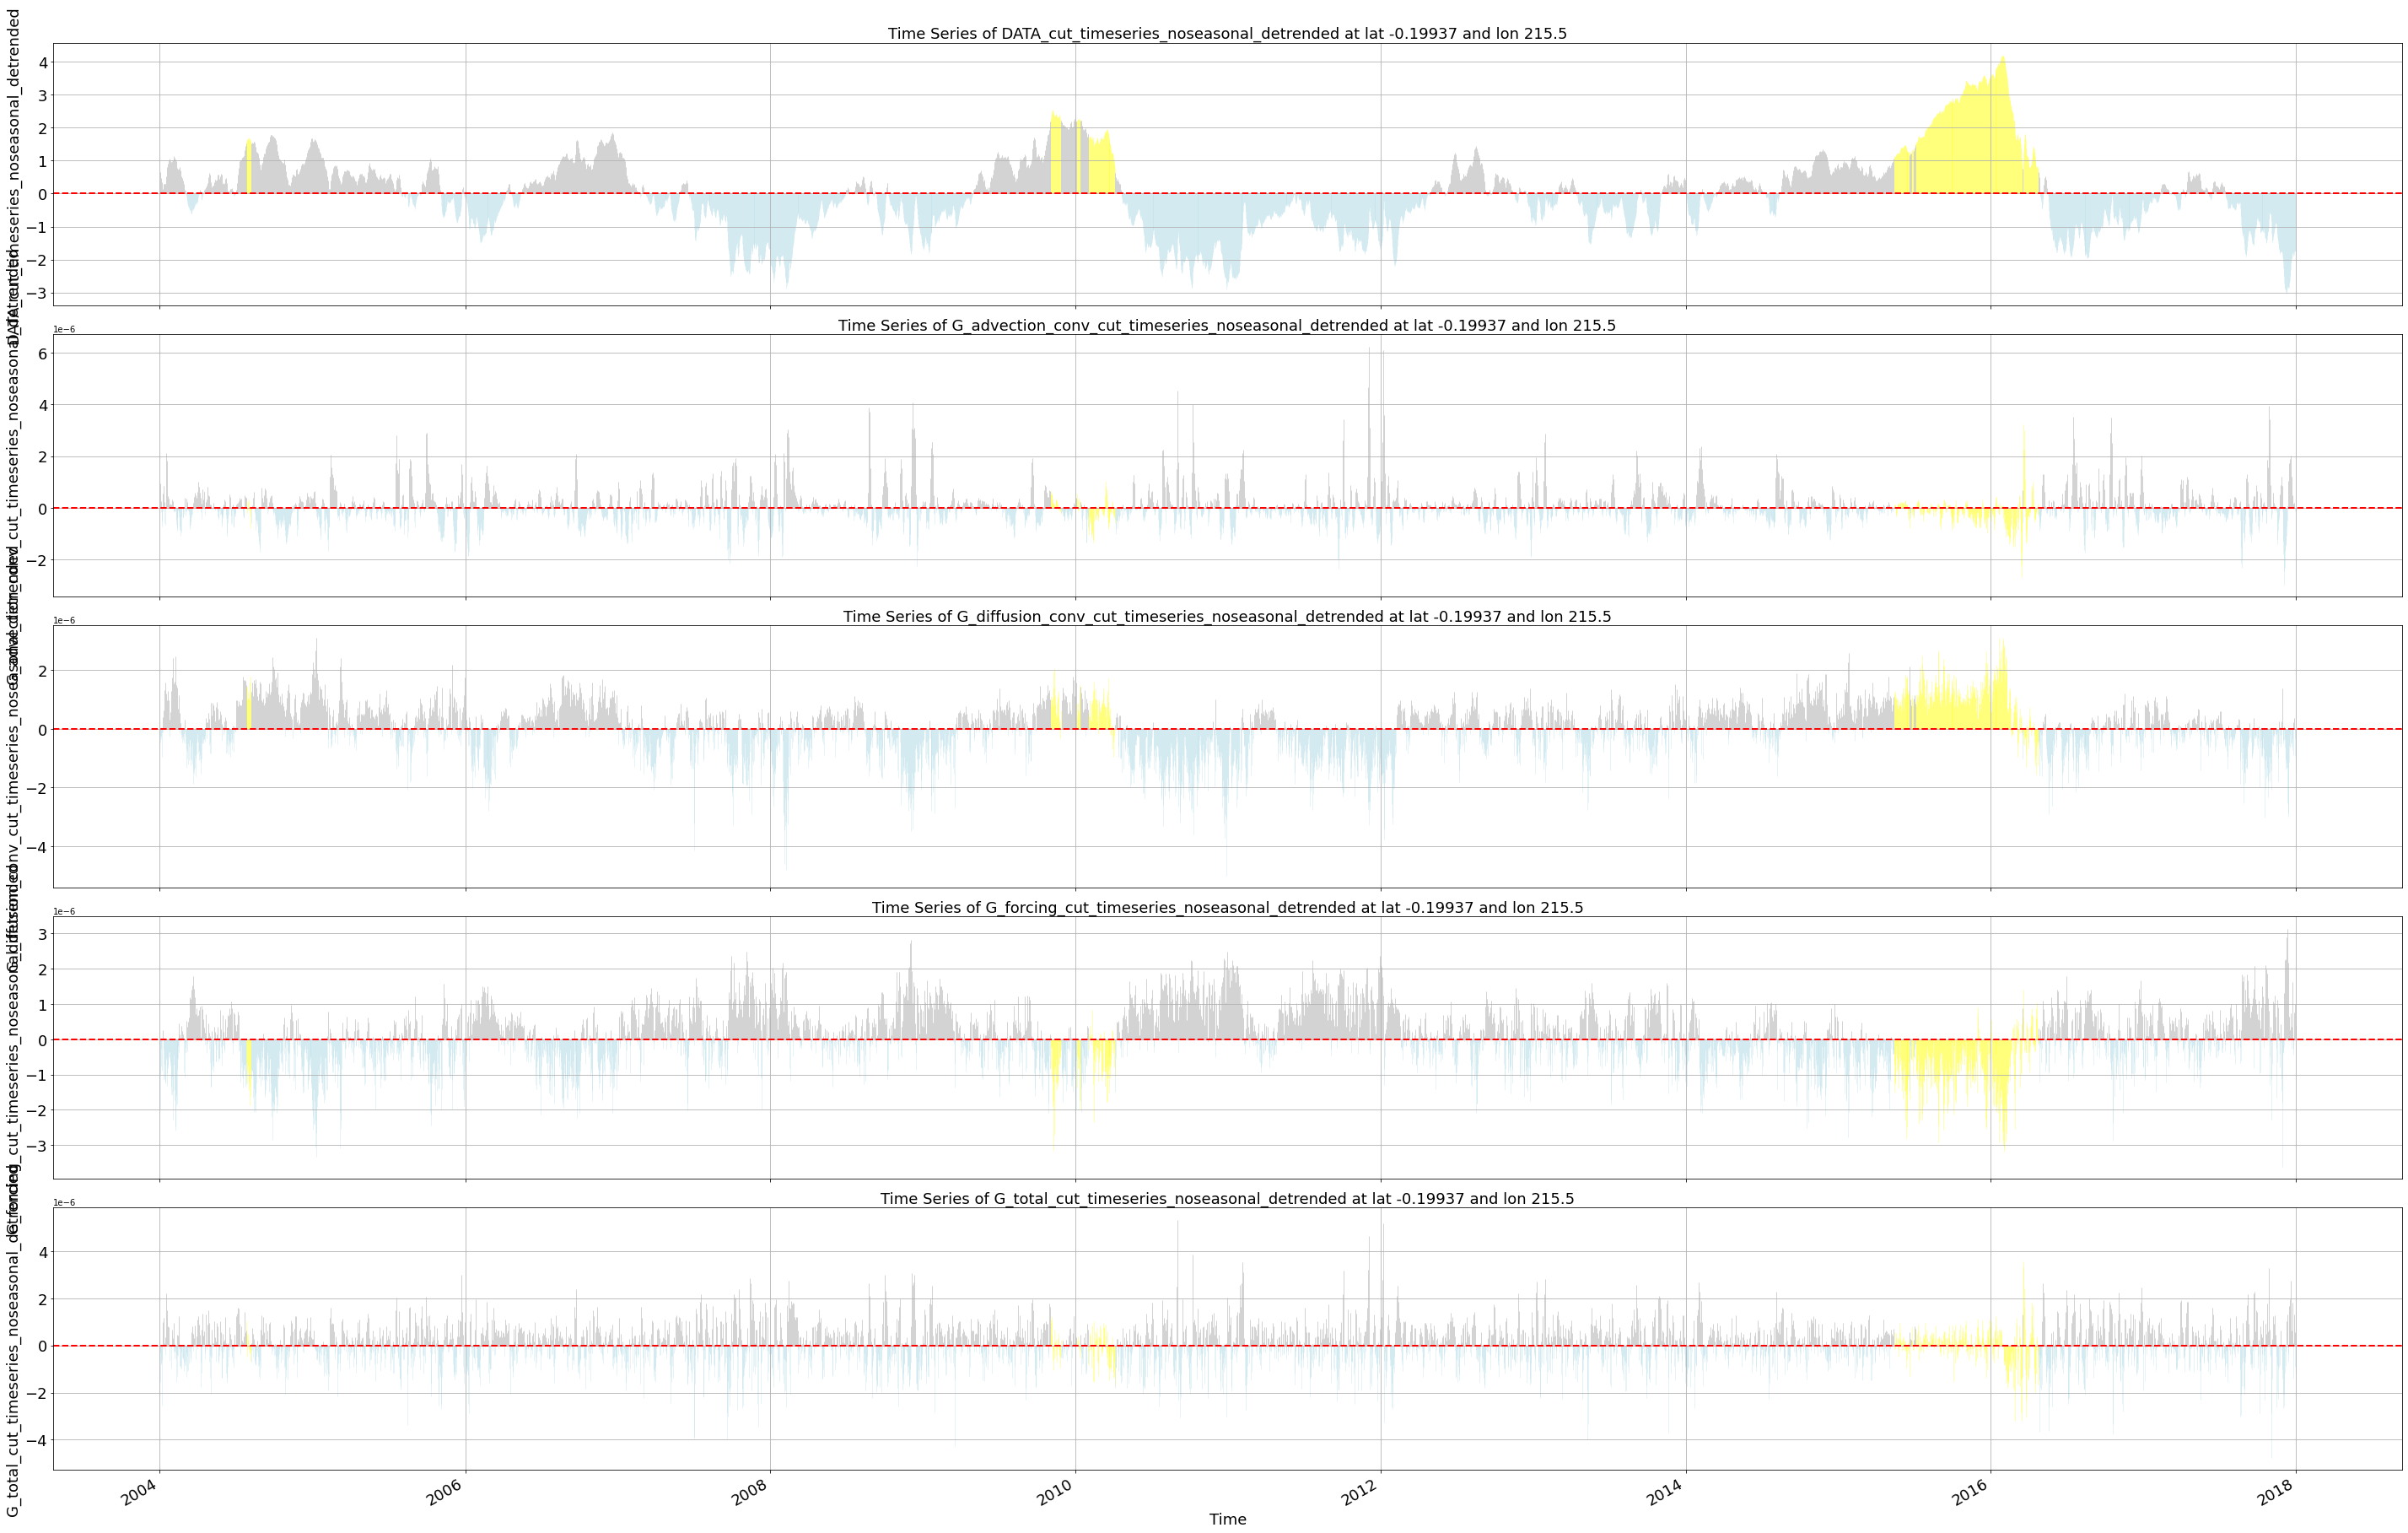

In [23]:
# Define your datasets and varnames
datasets = [
    DATA_cut_timeseries_noseasonal_detrended,
    G_advection_conv_cut_timeseries_noseasonal_detrended,
    G_diffusion_conv_cut_timeseries_noseasonal_detrended,
    G_forcing_cut_timeseries_noseasonal_detrended,
    G_total_cut_timeseries_noseasonal_detrended,
]

varnames = [
    'DATA_cut_timeseries_noseasonal_detrended',
    'G_advection_conv_cut_timeseries_noseasonal_detrended',
    'G_diffusion_conv_cut_timeseries_noseasonal_detrended',
    'G_forcing_cut_timeseries_noseasonal_detrended',
    'G_total_cut_timeseries_noseasonal_detrended',
]

MHW_start_index_array = MHW_detrended_noseasonal.start_tstep.dropna(dim='i').values
MHW_end_index_array = MHW_detrended_noseasonal.end_tstep.dropna(dim='i').values
MHW_selected_indexes = np.concatenate([np.arange(start, end + 1) for start, end in zip(MHW_start_index_array, MHW_end_index_array)])

# Create a single figure with multiple subplots
fig, axes = plt.subplots(len(datasets), 1, figsize=(40, 5 * len(datasets)))

# Define fontsize and line style/color for y=0 line
fontsize = 18

# Loop through datasets and varnames to plot each dataset in a subplot
for dataset, varname, ax in zip(datasets, varnames, axes):
    time_values = dataset.time.values
    values = dataset.values
    bar_width = 1  # Adjust width as needed
    bars = ax.bar(time_values, values, width=bar_width, align='center')

    # Assign colors to the bars based on their values
    for bar in bars:
        value = bar.get_height()
        if value > 0:
            bar.set_color('lightgray')
        elif value < 0:
            bar.set_color('lightblue')
            bar.set_alpha(0.3)
    
    # Change color of bars for MHWs
    i_bar = 0
    for bar in bars:
        if np.isin(i_bar, MHW_selected_indexes):
            bar.set_color('yellow')
            bar.set_alpha(0.3)
        i_bar = i_bar + 1
        
    # Highlight the line y=0
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)

    # Increase tick label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Set the x-axis to display date ticks nicely
    ax.xaxis_date()
    plt.xticks(rotation=45)
    fig.autofmt_xdate()

    ax.set_title(f'Time Series of {varname} at lat {desired_lat} and lon {desired_lon}', fontsize=fontsize)
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel(varname, fontsize=fontsize)
    ax.grid(True)

# Adjust layout spacing between subplots
plt.tight_layout()

# Save the figure as a high-quality PDF
savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
filename = f'heat_budget_terms_timeseries_noseasonal_detrended_barplot_lat_{desired_lat}_lon_{desired_lon}.pdf'
fig.savefig(savepath + filename, dpi=300, bbox_inches='tight')

# Show the single figure with all subplots
plt.show()


### Plot bar plot timeseries of heat budget terms + DATA as is for specific time period

In [ ]:
import matplotlib.pyplot as plt

# Define your datasets and varnames
datasets = [
    DATA_cut_timeseries,
    G_total_cut_timeseries,
    G_forcing_cut_timeseries,
    G_advection_conv_cut_timeseries,
    G_diffusion_conv_cut_timeseries
]

varnames = [
    'DATA_cut_timeseries',
    'G_total_cut_timeseries',
    'G_forcing_cut_timeseries',
    'G_advection_conv_cut_timeseries',
    'G_diffusion_conv_cut_timeseries'
]

# Define a list of time periods - for lon 203 and lat -35 
time_periods = [
    ('2004-03-01', '2005-12-31'),
    ('2008-02-01', '2008-04-30'),
    ('2008-12-01', '2009-04-30'),
    ('2009-12-01', '2011-04-30'),
    ('2013-01-31', '2013-06-30'),
    ('2013-09-01', '2014-01-31'),
    ('2014-04-01', '2014-08-30'),
    # Add more time periods as needed
    # ('start_time', 'end_time'),
]



# # Define a list of time periods - for lon 215 and lat -0.2 
# time_periods = [
#     ('2004-06-01', '2004-08-31'),
#     ('2005-04-01', '2005-06-30'),
#     ('2009-12-01', '2010-06-30'),
#     ('2015-03-01', '2016-05-31'),
#     # Add more time periods as needed
#     # ('start_time', 'end_time'),
# ]

# Loop over time periods
for start_time, end_time in time_periods:
    # Create a single figure with multiple subplots
    fig, axes = plt.subplots(len(datasets), 1, figsize=(40, 5 * len(datasets)))

    # Loop through datasets and varnames to plot each dataset in a subplot
    for dataset, varname, ax in zip(datasets, varnames, axes):
        dataset = dataset.sel(time=slice(start_time, end_time))  # Select specific time period

        time_values = dataset.time.values
        values = dataset.values
        bar_width = 1.2  # Adjust width as needed
        bars = ax.bar(time_values, values, width=bar_width, align='center')

        # Assign colors to the bars based on their values
        for bar in bars:
            value = bar.get_height()
            if value > 0:
                bar.set_color('lightgray')
            elif value < 0:
                bar.set_color('lightblue')
                bar.set_alpha(0.3)

        # Increase tick label fontsize
        fontsize = 18
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        # Set the x-axis to display date ticks nicely
        ax.xaxis_date()
        plt.xticks(rotation=45)
        fig.autofmt_xdate()

        ax.set_title(f'Time Series of {varname} from {start_time} and {end_time}, at lat {desired_lat} and lon {desired_lon}', fontsize=fontsize)
        ax.set_xlabel('Time', fontsize=fontsize)
        ax.set_ylabel(varname, fontsize=fontsize)
        ax.grid(True)

    # Adjust layout spacing between subplots
    plt.tight_layout()

    # Save the figure as a high-quality PDF
    savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
    filename = f'heat_budget_terms_timeseries_barplot_lat_{desired_lat}_lon_{desired_lon}_{start_time}_{end_time}.png'
    fig.savefig(savepath + filename, dpi=300, bbox_inches='tight')

    # Show the single figure with all subplots
    plt.show()


### Plot bar plot timeseries of heat budget terms + DATA without trend and seasonal cycle for specific time period

In [ ]:
import matplotlib.pyplot as plt

# Define your datasets and varnames
datasets = [
    DATA_cut_timeseries_noseasonal_detrended,
    G_total_cut_timeseries_noseasonal_detrended,
    G_forcing_cut_timeseries_noseasonal_detrended,
    G_advection_conv_cut_timeseries_noseasonal_detrended,
    G_diffusion_conv_cut_timeseries_noseasonal_detrended
]

varnames = [
    'DATA_cut_timeseries_noseasonal_detrended',
    'G_total_cut_timeseries_noseasonal_detrended',
    'G_forcing_cut_timeseries_noseasonal_detrended',
    'G_advection_conv_cut_timeseries_noseasonal_detrended',
    'G_diffusion_conv_cut_timeseries_noseasonal_detrended'
]

# Define a list of time periods - for lon 203 and lat -35 
# time_periods = [
#     ('2004-03-01', '2005-12-31'),
#     ('2008-02-01', '2008-04-30'),
#     ('2008-12-01', '2009-04-30'),
#     ('2009-12-01', '2011-04-30'),
#     ('2013-01-31', '2013-06-30'),
#     ('2013-09-01', '2014-01-31'),
#     ('2014-04-01', '2014-08-30'),
#     # Add more time periods as needed
#     # ('start_time', 'end_time'),
# ]
# time_periods = [
#     ('2008-04-02', '2010-12-28'),
#     ('2004-02-23', '2016-06-19')
# ]


# # Define a list of time periods - for lon 215 and lat -0.2 
# time_periods = [
#     ('2004-06-01', '2004-08-31'),
#     ('2005-04-01', '2005-06-30'),
#     ('2009-12-01', '2010-06-30'),
#     ('2015-03-01', '2016-05-31'),
#     # Add more time periods as needed
#     # ('start_time', 'end_time'),
# ]
time_periods = [
    ('2004-02-04', '2016-06-19'),
    ('2008-04-02', '2010-12-28'),
    ('2015-03-27', '2016-06-19')
]

# Loop over time periods
for start_time, end_time in time_periods:
    # Create a single figure with multiple subplots
    fig, axes = plt.subplots(len(datasets), 1, figsize=(40, 5 * len(datasets)))

    # Loop through datasets and varnames to plot each dataset in a subplot
    for dataset, varname, ax in zip(datasets, varnames, axes):
        dataset = dataset.sel(time=slice(start_time, end_time))  # Select specific time period

        time_values = dataset.time.values
        values = dataset.values
        bar_width = 1.2  # Adjust width as needed
        bars = ax.bar(time_values, values, width=bar_width, align='center')

        # Assign colors to the bars based on their values
        for bar in bars:
            value = bar.get_height()
            if value > 0:
                bar.set_color('lightgray')
            elif value < 0:
                bar.set_color('lightblue')
                bar.set_alpha(0.3)

        # Increase tick label fontsize
        fontsize = 18
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        # Set the x-axis to display date ticks nicely
        ax.xaxis_date()
        plt.xticks(rotation=45)
        fig.autofmt_xdate()

        ax.set_title(f'Time Series of {varname} from {start_time} and {end_time}, at lat {desired_lat} and lon {desired_lon}', fontsize=fontsize)
        ax.set_xlabel('Time', fontsize=fontsize)
        ax.set_ylabel(varname, fontsize=fontsize)
        ax.grid(True)

    # Adjust layout spacing between subplots
    plt.tight_layout()

    # Save the figure as a high-quality PDF
    savepath = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/timeseries_heat_budget_terms/'
    filename = f'heat_budget_terms_timeseries_noseasonal_detrended_barplot_lat_{desired_lat}_lon_{desired_lon}_{start_time}_{end_time}.png'
    fig.savefig(savepath + filename, dpi=300, bbox_inches='tight')

    # Show the single figure with all subplots
    plt.show()


In [ ]:
ciao

### Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

# Define the time range from 2014-01-01 to 2016-12-31
start_date = '2014-01-01'
end_date = '2016-12-31'

# Filter the data for the specified time range
data_in_filtered = data_in.sel(time=slice(start_date, end_date))

# Convert 'time' coordinate to datetime
time_data = pd.to_datetime(data_in_filtered['time'].values)

# Create a bar plot of the filtered data
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# You can customize the plot further to your preference
sns.barplot(x=time_data, y=data_in_filtered.values, color='blue')
plt.title('Time Series Bar Plot (2014-2016)')
plt.xlabel('Time')
plt.ylabel('Value')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
d2plot_map_list = ['G_advection_conv_cut']
d2plot_map_timestart = np.datetime64('2010-06-16T12:00:00.000000000')
d2plot_map_timeend = np.datetime64('2010-06-16T12:00:00.000000000')


In [ ]:
for ivar in d2plot_map_list:
    d2plot_map = eval(ivar)
    itime_all = np.where((d2plot_map.time.values >= d2plot_map_timestart) \
                         & (d2plot_map.time.values <= d2plot_map_timeend))[0]
    for ilev in d2plot_map_levels:
        ilev_ind = np.where(Z_depth == ilev)[0][0]
        for itime in itime_all:
            plt.figure(figsize=(15,15))
            p = ecco.plot_proj_to_latlon_grid(XC_lon, YC_lat, d2plot.isel(k=ilev_ind, time = itime), show_colorbar=True,
                                              cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, subplot_grid=[3,1,idx+1])
             
            
            
            

In [ ]:
d2plot_map

In [ ]:
import ecco_v4_py
import xarray as xr

# Load your xarray.Dataset (assuming you have it loaded)

# Extract the longitude, latitude, and the field variable
orig_lons = dataset['i'].values  # Assuming 'i' corresponds to longitude
orig_lats = dataset['j'].values  # Assuming 'j' corresponds to latitude
orig_field = dataset['G_total_cut'].values  # Replace 'G_total_cut' with your variable name

# Define the target grid parameters
new_grid_delta_lat = 1 # Latitudinal extent of new grid cells in degrees (-90..90)
new_grid_delta_lon = 1 # Longitudinal extent of new grid cells in degrees

new_grid_min_lat = -90 # Minimum latitude of the new grid
new_grid_max_lat = 90 # Maximum latitude of the new grid

new_grid_min_lon = -180 # Minimum longitude of the new grid (-180..180)
new_grid_max_lon = 180 # Maximum longitude of the new grid

# Optional parameters
radius_of_influence = 120000  # Radius within which to search for input data (default 120000 m)
fill_value = None  # Value to use in the new grid if no valid values are found (default None)
mapping_method = 'bin_average'  # Interpolation method (default 'bin_average')

# Call the resample_to_latlon function
new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, data_latlon_projection = ecco_v4_py.resample_to_latlon(
    orig_lons, orig_lats, orig_field,
    new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)



In [ ]:
# Define the save and load directories
year_start = 2004
year_end = 2018
z_lev = 0
z_flag = 'zlev'
# z_flag = 'zint'

# Define the lat/lon coordinates for the point (0N, 145W)
lat_point = 0  # Latitude
lon_point = 215  # Convert 145W to 215E

# Loop through the variables
for varname in varnames:
    final_dataset = None  # Initialize final dataset for each variable
    
    # Loop through the years from 2004 to 2018
    for year in range(year_start, year_end):
        # Define the folder name for the current year
        folder_year = str(year)

        # Create the directory path for loading
        load_path = os.path.join(save_dir, 'nc_files_zlev_or_zint')

        # Define the file name for loading
        load_file_name = f'ECCOv4r4_{varname}_{z_flag}{z_lev}_{year_start}_{year_end}.nc'

        # Load the NetCDF file from the specified directory
        load_file_path = os.path.join(load_path, load_file_name)
        dataset = xr.open_dataset(load_file_path)
        
        # Select the data at the specified lat/lon point
        data_at_point = dataset.sel(lat=lat_point, lon=lon_point, method='nearest')

        # Append the data to the time series list for the current variable
        time_series_data[varname].append(data_at_point)

# Plot the time series for each variable
for varname, data_list in time_series_data.items():
    plt.figure(figsize=(10, 5))
    plt.plot(data_list)
    plt.title(f'Time Series of {varname} at (0N, 145W)')
    plt.xlabel('Time')
    plt.ylabel(varname)
    plt.grid(True)
    plt.show()
        

In [ ]:
# Commands to create timeseries plots for one specific tile

# ds = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/outputs/nc_files_zlev_or_zint/ECCOv4r4_G_total_cut_zlev0_2004_2018.nc')
# ds9 = ds.sel(tile=9)
# ds8 = ds.sel(tile=8)

# import xarray as xr
# import matplotlib.pyplot as plt

# # Assuming you have already loaded the xarray.Dataset
# # For demonstration purposes, let's call the dataset "data"

# # Selecting a specific location (i, j)
# i_val = 12
# j_val = 34

# # Extracting the time series for the selected location
# time_series = ds8.G_total_cut.sel(i=i_val, j=j_val)

# # Plotting the time series
# plt.figure(figsize=(30, 6))
# time_series.plot()
# plt.title(f"Time Series from tile 9")
# plt.xlabel("Time")
# plt.ylabel("G_total_cut values")
# plt.show()


# import xarray as xr
# import matplotlib.pyplot as plt

# # Assuming you have already loaded the xarray.Dataset
# # For demonstration purposes, let's call the dataset "data"

# # Selecting a specific location (i, j)
# i_val = 12
# j_val = 34

# # Extracting the time series for the selected location
# time_series = ds9.G_total_cut.sel(i=i_val, j=j_val)

# # Plotting the time series
# plt.figure(figsize=(30, 6))
# time_series.plot()
# plt.title(f"Time Series at location (i={i_val}, j={j_val})")
# plt.xlabel("Time")
# plt.ylabel("G_total_cut values")
# plt.show()
